## Steps to follow

1. Get train test split
1. Fit default model. Also fit using cross validation
2. Evaluate the model
3. Change parameters and hyperparameters
4. Evaluate all models
5. Compare all models
6. Find out feature importance

### Load the libraries

In [23]:
# imoprt libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import log_loss,classification_report,confusion_matrix, roc_curve, roc_auc_score,accuracy_score

import matplotlib.pyplot as plt

# over sampling for imbalanced classes
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, RandomUnderSampler, NearMiss, EditedNearestNeighbours, RepeatedEditedNearestNeighbours,InstanceHardnessThreshold
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.pipeline import make_pipeline

from collections import Counter

# calculate weights for imbablanced classes
from sklearn.utils import class_weight


### Load the data

In [2]:
# should I use normalized data for all models?
# using pca components instead of normal features is a good idea? I don't think so.
# for logistic regression it is better to use nomralized data

df = pd.read_csv("../data/train_norm.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,target
0,0.402093,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,...,0.246100,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,1
1,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,...,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,1
2,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,0.149647,-0.291038,-0.243606,...,-0.280099,-0.420870,-0.249802,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,1
3,0.402093,-0.210106,-0.307165,0.079240,13.508710,4.524667,4.665884,-0.293664,-0.291038,0.679472,...,-0.280099,-0.047949,1.019683,-0.413584,-0.299712,-0.176699,-0.129516,-0.386938,-0.104963,1
4,-0.253508,-0.210106,-0.307165,-0.279443,-0.161867,-0.119331,-0.188045,-0.293664,-0.291038,-0.243606,...,0.246100,-0.420870,-0.249802,-0.413584,-0.299712,0.040798,-0.129516,-0.386938,-0.104963,1


### Split the data into train test

In [3]:
# here the classes are imbalanced so we should use stratified split 
# the folds are made by preserving the percentage of samples for each class
# note that the imbalance will still be their when we train the model using this split

# since we have big amount of data our test set can be just 1% of all data
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=42)
print(sss)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.1,
            train_size=None)


In [4]:
X = df.drop("target",axis=1)
y = df.target

train_index = []
test_index = []

for tr, tes in sss.split(X,y):
    print("TRAIN:", tr, "TEST:", tes)
    train_index = tr
    test_index = tes

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]


TRAIN: [57972 30244  9427 ..., 60232 28576 27516] TEST: [59081 21681 51999 ...,  1777   269 53901]


In [5]:
print("Shapes of data sets")
print("X_train: ", X_train.shape, "y_train: ", y_train.shape)
print("X_train: ", X_test.shape,"y_test: ", y_test.shape)

Shapes of data sets
X_train:  (55690, 93) y_train:  (55690,)
X_train:  (6188, 93) y_test:  (6188,)


### Model evaluation function

In [6]:
def evaluate_model(m):
    print("Train score: ",m.score(X_train,y_train).round(5))
    print("Test score: ",m.score(X_test,y_test).round(5))
    print("Log loss train: ",log_loss(y_train, m.predict_proba(X_train)).round(5))
    print("Log loss test: ",log_loss(y_test, m.predict_proba(X_test)).round(5))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, m.predict(X_test),labels=m.classes_))
    print("\nClassification Report: \n", classification_report(y_test, m.predict(X_test)))
    

In [7]:
def evaluate_model_balance(m,y_train,y_test):
    print("Train score: ",m.score(X_train,y_train).round(5))
    print("Test score: ",m.score(X_test,y_test).round(5))
    print("Log loss train: ",log_loss(y_train, m.predict_proba(X_train)).round(5))
    print("Log loss test: ",log_loss(y_test, m.predict_proba(X_test)).round(5))
    print("\nConfusion Matrix: \n", confusion_matrix(y_test, m.predict(X_test),labels=m.classes_))
    print("\nClassification Report: \n", classification_report(y_test, m.predict(X_test)))

### Feature importance function

In [8]:
def feature_imp(m):
    coef_df = pd.DataFrame(m.coef_)
    coef_df = np.absolute(np.round(coef_df,5))

    imp_features = [0]*9
    for row in np.arange(0,9,1):
        # top coefficients for each class
        imp_features[row] = sorted(enumerate(coef_df.iloc[row]), \
                                   key=lambda x:x[1],reverse=True)[0:5]

    print("Most important features: \n",np.unique(np.transpose(imp_features)[0])+1)


### Fit on default model

In [10]:
lr = LogisticRegression(random_state=42)

In [11]:
lr.fit(X=X_train,y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
evaluate_model(lr)

Train score:  0.75716
Test score:  0.75533
Log loss train:  0.66281
Log loss test:  0.67151

Confusion Matrix: 
 [[  56   27    0    0    0   21    2   41   46]
 [   0 1438  138    5    8    6   10    5    2]
 [   0  565  217    3    0    1   10    3    1]
 [   0  168   29   45    4   19    4    0    0]
 [   0   15    2    0  257    0    0    0    0]
 [   3   34    1    3    0 1301   23   29   20]
 [   2   55   20    1    0   30  159   14    3]
 [  10   16    2    0    0   27   10  772    9]
 [   5   26    0    1    0   15    1   19  429]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.74      0.29      0.42       193
          2       0.61      0.89      0.73      1612
          3       0.53      0.27      0.36       800
          4       0.78      0.17      0.28       269
          5       0.96      0.94      0.95       274
          6       0.92      0.92      0.92      1414
          7       0.73      0.56      0.63       284
   

In [13]:
feature_imp(lr)

Most important features: 
 [  9.  11.  14.  15.  26.  27.  34.  39.  40.  42.  43.  45.  47.  58.  60.
  69.  73.  75.  76.  78.  83.  84.  86.  90.]


### Use cross validation

In [39]:
# using LogisticRegressionCV
params = {"cv":5, "random_state":42}
lrcv = LogisticRegressionCV(params)


In [15]:
lrcv.fit(X=X_train,y=y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [16]:
evaluate_model(lrcv)

Train score:  0.75726
Test score:  0.75727
Log loss train:  0.66178
Log loss test:  0.6707

Confusion Matrix: 
 [[  57   25    0    0    0   21    3   41   46]
 [   0 1442  137    4    6    6   10    5    2]
 [   0  561  221    3    0    1   10    3    1]
 [   0  168   30   44    4   19    4    0    0]
 [   0   13    2    0  259    0    0    0    0]
 [   3   35    1    3    1 1302   23   27   19]
 [   2   53   20    1    1   30  160   14    3]
 [  11   17    1    0    0   26    9  773    9]
 [   5   27    0    1    0   15    1   19  428]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.73      0.30      0.42       193
          2       0.62      0.89      0.73      1612
          3       0.54      0.28      0.36       800
          4       0.79      0.16      0.27       269
          5       0.96      0.95      0.95       274
          6       0.92      0.92      0.92      1414
          7       0.73      0.56      0.63       284
    

In [17]:
feature_imp(lrcv)

Most important features: 
 [  9.  11.  14.  15.  26.  27.  36.  39.  40.  42.  43.  45.  47.  58.  59.
  60.  68.  69.  73.  75.  76.  83.  84.  86.  90.]


In [31]:
#C_param_range = [0.001,0.01,0.1,1,10,100]
C_param_range = [100,300,1000]
gcv = GridSearchCV(estimator=lr, cv=3,scoring="neg_log_loss",param_grid={"C":C_param_range})


In [32]:
gcv.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [100, 300, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='neg_log_loss',
       verbose=0)

In [33]:
C_best = gcv.best_estimator_.C

In [34]:
C_best

100

In [57]:
gcv.best_estimator_

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [79]:
# using LogisticRegressionCV
params = {"cv":3,"random_state":32}
params.update({"Cs":100})
print(params)
lrcv2 = LogisticRegressionCV()
lrcv2.set_params(**params)
#lrcv2.fit(X_train,y_train)

{'cv': 3, 'random_state': 32, 'Cs': 100}


LogisticRegressionCV(Cs=100, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=32,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [29]:
lrcv2.get_params

<bound method BaseEstimator.get_params of LogisticRegressionCV(Cs=100, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)>

In [30]:
evaluate_model(lrcv2)

Train score:  0.75734
Test score:  0.7563
Log loss train:  0.66156
Log loss test:  0.67022

Confusion Matrix: 
 [[  57   26    0    0    0   21    2   41   46]
 [   0 1442  137    4    6    6   10    5    2]
 [   0  565  219    1    0    1   10    3    1]
 [   0  172   29   41    4   19    4    0    0]
 [   0   13    2    0  259    0    0    0    0]
 [   3   35    1    3    1 1301   23   27   20]
 [   2   53   20    1    1   30  160   14    3]
 [  11   17    1    0    0   27    9  772    9]
 [   5   26    0    1    0   15    1   19  429]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.73      0.30      0.42       193
          2       0.61      0.89      0.73      1612
          3       0.54      0.27      0.36       800
          4       0.80      0.15      0.26       269
          5       0.96      0.95      0.95       274
          6       0.92      0.92      0.92      1414
          7       0.73      0.56      0.64       284
    

In [35]:
lrcv3 = LogisticRegressionCV(cv=3, random_state=42,Cs=C_best,scoring=('neg_log_loss'))
lrcv3.fit(X_train,y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
           refit=True, scoring='neg_log_loss', solver='lbfgs', tol=0.0001,
           verbose=0)

In [36]:
evaluate_model(lrcv3)

Train score:  0.75707
Test score:  0.75533
Log loss train:  0.66288
Log loss test:  0.67171

Confusion Matrix: 
 [[  57   27    0    0    0   21    2   40   46]
 [   0 1439  138    5    7    6   10    5    2]
 [   0  565  218    2    0    1   11    3    0]
 [   0  168   29   44    4   19    5    0    0]
 [   0   15    2    0  257    0    0    0    0]
 [   3   36    1    3    1 1302   22   26   20]
 [   2   55   21    1    0   31  157   14    3]
 [  11   17    1    0    0   28    9  771    9]
 [   5   26    0    1    0   15    1   19  429]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.73      0.30      0.42       193
          2       0.61      0.89      0.73      1612
          3       0.53      0.27      0.36       800
          4       0.79      0.16      0.27       269
          5       0.96      0.94      0.95       274
          6       0.91      0.92      0.92      1414
          7       0.72      0.55      0.63       284
   

### Use cross validation library

In [216]:
cross_validate(estimator=lr,cv=3,X=X_train,y=y_train,scoring=('neg_log_loss'))

{'fit_time': array([ 15.76905894,  15.40101194,  14.45040584]),
 'score_time': array([ 0.01995587,  0.0199542 ,  0.01813412]),
 'test_score': array([-0.68030046, -0.67570131, -0.6716733 ]),
 'train_score': array([-0.65810914, -0.66169568, -0.66303738])}

### Naive random over sampling

In [250]:
rs = RandomOverSampler(random_state=42)

In [254]:
X_os, y_os = rs.fit_sample(X_train,y_train)

In [255]:
X_os.shape, y_os.shape

((130590, 93), (130590,))

In [256]:
lr = LogisticRegression()

In [257]:
lr.fit(X=X_os,y=y_os)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [258]:
evaluate_model(lr)

Train score:  0.71501
Test score:  0.71025
Log loss train:  0.78172
Log loss test:  0.79707

Confusion Matrix: 
 [[ 140    2    2    2    2    3    7   14   21]
 [  23  909  329  291   17    3   32    3    5]
 [   2  205  371  175    2    1   41    0    3]
 [   0   38   28  181    5    7   10    0    0]
 [   1    3    2    0  268    0    0    0    0]
 [  58    7    4   22    2 1215   46   21   39]
 [  19    7   16   17    0    3  215    4    3]
 [  81    3    4    0    0   12   19  714   13]
 [  79    5    1    5    0   10    3   11  382]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.35      0.73      0.47       193
          2       0.77      0.56      0.65      1612
          3       0.49      0.46      0.48       800
          4       0.26      0.67      0.38       269
          5       0.91      0.98      0.94       274
          6       0.97      0.86      0.91      1414
          7       0.58      0.76      0.65       284
   

In [259]:
feature_imp(lr)

Most important features: 
 [ 11.  14.  15.  19.  26.  34.  39.  43.  45.  47.  58.  59.  60.  69.  73.
  75.  76.  78.  83.  84.  86.  90.  91.  92.]


Above naive random over sampling did worse results then our original data.

#### SMOTE, ADASYN oversampling

In [261]:
smote = SMOTE(random_state=42)

In [262]:
X_os, y_os = smote.fit_sample(X_train,y_train)

In [263]:
X_os.shape, y_os.shape

((130590, 93), (130590,))

In [264]:
lr = LogisticRegression()

In [265]:
lr.fit(X=X_os,y=y_os)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [266]:
evaluate_model(lr)

Train score:  0.71354
Test score:  0.70814
Log loss train:  0.76569
Log loss test:  0.78492

Confusion Matrix: 
 [[ 137    3    1    2    1    3    8   17   21]
 [  27  866  350  304   13    4   40    3    5]
 [   2  185  382  184    2    1   42    0    2]
 [   0   37   29  181    5    7   10    0    0]
 [   1    3    2    0  268    0    0    0    0]
 [  55    7    3   21    2 1224   45   21   36]
 [  19    6   14   15    0    4  217    5    4]
 [  68    2    4    0    0   12   23  724   13]
 [  77    4    1    5    0   12    3   11  383]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.35      0.71      0.47       193
          2       0.78      0.54      0.64      1612
          3       0.49      0.48      0.48       800
          4       0.25      0.67      0.37       269
          5       0.92      0.98      0.95       274
          6       0.97      0.87      0.91      1414
          7       0.56      0.76      0.65       284
   

In [267]:
adasyn = ADASYN(n_neighbors=5,random_state=42)

In [268]:
X_os, y_os = adasyn.fit_sample(X_train,y_train)

In [269]:
X_os.shape, y_os.shape

((131124, 93), (131124,))

In [270]:
lr = LogisticRegression()

In [271]:
lr.fit(X=X_os,y=y_os)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [272]:
evaluate_model(lr)

Train score:  0.69154
Test score:  0.68714
Log loss train:  0.81283
Log loss test:  0.8348

Confusion Matrix: 
 [[ 122    2    1    1    2    2   12   18   33]
 [  25  778  334  327   70    1   53    9   15]
 [   2  159  351  200   20    1   55    8    4]
 [   0   24   27  187    9    6   13    0    3]
 [   0    1    2    0  271    0    0    0    0]
 [  44    3    1   11   11 1199   53   36   56]
 [  14    4   10   16    3    4  223    6    4]
 [  54    4    2    0    3    8   24  732   19]
 [  69    1    2    3    7    7    6   12  389]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.37      0.63      0.47       193
          2       0.80      0.48      0.60      1612
          3       0.48      0.44      0.46       800
          4       0.25      0.70      0.37       269
          5       0.68      0.99      0.81       274
          6       0.98      0.85      0.91      1414
          7       0.51      0.79      0.62       284
    

### Prototype generation under sampling

In [274]:
cc = ClusterCentroids(random_state=42)

In [275]:
X_os, y_os = cc.fit_sample(X_train,y_train)

In [276]:
X_os.shape, y_os.shape

((15624, 93), (15624,))

In [277]:
lr = LogisticRegression()

In [278]:
lr.fit(X=X_os,y=y_os)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [279]:
evaluate_model(lr)

Train score:  0.59224
Test score:  0.58759
Log loss train:  0.97031
Log loss test:  0.99595

Confusion Matrix: 
 [[ 149    2    2    3    2    3    6    9   17]
 [  72  453  280  744   36    1   20    2    4]
 [  16   99  312  337    7    1   27    0    1]
 [   6   14   17  218    6    3    5    0    0]
 [   3    1    0    1  269    0    0    0    0]
 [ 136    4    5   50    4 1131   37   15   32]
 [  34    3   14   33    2    1  191    3    3]
 [ 187    5    6    6    4   11   21  592   14]
 [ 155    1    0    7    0    5    1    6  321]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.20      0.77      0.31       193
          2       0.78      0.28      0.41      1612
          3       0.49      0.39      0.43       800
          4       0.16      0.81      0.26       269
          5       0.82      0.98      0.89       274
          6       0.98      0.80      0.88      1414
          7       0.62      0.67      0.65       284
   

### Random under sampling

In [282]:
rus = RandomUnderSampler(random_state=42)

In [284]:
X_os, y_os = rus.fit_sample(X_train,y_train)
print(X_os.shape, y_os.shape)
lr = LogisticRegression()
lr.fit(X=X_os,y=y_os)
evaluate_model(lr)

(15624, 93) (15624,)
Train score:  0.71424
Test score:  0.71202
Log loss train:  0.79894
Log loss test:  0.81376

Confusion Matrix: 
 [[ 137    0    2    2    2    3    8   17   22]
 [  22  927  320  275   20    2   35    4    7]
 [   3  207  368  176    6    1   35    2    2]
 [   0   38   33  177    6    7    8    0    0]
 [   2    3    2    0  267    0    0    0    0]
 [  53    6    5   24    1 1216   49   26   34]
 [  20    6   20   14    1    5  212    4    2]
 [  76    3    5    0    0   12   19  717   14]
 [  79    4    1    4    0    9    5    9  385]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.35      0.71      0.47       193
          2       0.78      0.58      0.66      1612
          3       0.49      0.46      0.47       800
          4       0.26      0.66      0.38       269
          5       0.88      0.97      0.93       274
          6       0.97      0.86      0.91      1414
          7       0.57      0.75   

### Near miss under sampling

In [290]:
def fit_evaluate(sampling, X_train, y_train):
    X_os, y_os = sampling.fit_sample(X_train,y_train)
    print(X_os.shape, y_os.shape)
    lr = LogisticRegression()
    lr.fit(X=X_os,y=y_os)
    evaluate_model(lr)

In [287]:
nm1 = NearMiss(random_state=0, version=1,n_neighbors=5)

In [288]:
X_os, y_os = nm1.fit_sample(X_train,y_train)
print(X_os.shape, y_os.shape)
lr = LogisticRegression()
lr.fit(X=X_os,y=y_os)
evaluate_model(lr)

(15624, 93) (15624,)
Train score:  0.53974
Test score:  0.54945
Log loss train:  2.37182
Log loss test:  2.35544

Confusion Matrix: 
 [[ 111    6    0    4    1    8    9   17   37]
 [  23  337  226  739   76    9  186   10    6]
 [   2   59  161  320   41    2  202   12    1]
 [   0   16   31  191    4    4   22    0    1]
 [   0    4    0    4  265    0    0    0    1]
 [  82    5    0   47    2 1137   97   25   19]
 [  11   10    7    8    1    6  235    4    2]
 [  90    5    1    5    0   16   63  651   15]
 [ 121    9    1   21    0   10    7   15  312]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.25      0.58      0.35       193
          2       0.75      0.21      0.33      1612
          3       0.38      0.20      0.26       800
          4       0.14      0.71      0.24       269
          5       0.68      0.97      0.80       274
          6       0.95      0.80      0.87      1414
          7       0.29      0.83   

In [291]:
nm2 = NearMiss(random_state=42, version=2,n_neighbors=3)

In [292]:
fit_evaluate(nm2, X_train, y_train)

(15624, 93) (15624,)
Train score:  0.57298
Test score:  0.57143
Log loss train:  1.01909
Log loss test:  1.03002

Confusion Matrix: 
 [[ 112    1    2    6    1    4   10   13   44]
 [  10  300  123 1073   32    5   43    3   23]
 [   1  115  161  477    3    0   32    3    8]
 [   0   12    4  238    5    4    6    0    0]
 [   0    1    2    2  267    0    0    1    1]
 [  31    3    3   66    4 1193   47   19   48]
 [  11    3    6   36    1    6  212    5    4]
 [  53    7    6    4    0   29   23  683   41]
 [  74    1    3   19    0   11    7   11  370]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.38      0.58      0.46       193
          2       0.68      0.19      0.29      1612
          3       0.52      0.20      0.29       800
          4       0.12      0.88      0.22       269
          5       0.85      0.97      0.91       274
          6       0.95      0.84      0.89      1414
          7       0.56      0.75   

In [294]:
nm3 = NearMiss(random_state=42, version=3,n_neighbors_ver3=5)

In [295]:
fit_evaluate(nm3, X_train, y_train)

/anaconda3/lib/python3.6/site-packages/imblearn/under_sampling/prototype_selection/nearmiss.py:211: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn('The number of the samples to be selected is larger'


(11781, 93) (11781,)
Train score:  0.69962
Test score:  0.70023
Log loss train:  0.88521
Log loss test:  0.89183

Confusion Matrix: 
 [[  97    7    4    1    2   15    2   26   39]
 [  10  888  395  268   20    8   15    6    2]
 [   1  300  373   94    3    1   26    2    0]
 [   1   55   60  133    5    7    7    0    1]
 [   0    2    3    0  266    0    0    2    1]
 [   8   15    4   10   15 1280   35   28   19]
 [   7   19   30    9    0   15  189   13    2]
 [  21    8   11    1    2   59   18  716   10]
 [  46   10    3    4    0   18    1   23  391]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.51      0.50      0.51       193
          2       0.68      0.55      0.61      1612
          3       0.42      0.47      0.44       800
          4       0.26      0.49      0.34       269
          5       0.85      0.97      0.91       274
          6       0.91      0.91      0.91      1414
          7       0.65      0.67   

### Tomek links

In [298]:
enn = EditedNearestNeighbours(random_state=42)

In [299]:
fit_evaluate(enn, X_train, y_train)

(32804, 93) (32804,)
Train score:  0.75139
Test score:  0.7521
Log loss train:  0.81867
Log loss test:  0.82391

Confusion Matrix: 
 [[ 118   16    0    1    1   12    3   21   21]
 [  10 1454  112    5    9    9    9    3    1]
 [   3  570  199    2    0    1   21    2    2]
 [   0  181   35   25    4   18    5    1    0]
 [   0   14    1    0  259    0    0    0    0]
 [  26   32    0    2    0 1298   20   20   16]
 [  31   37   21    0    1   19  160   13    2]
 [  40   11    1    1    0   22    8  759    4]
 [  64   17    1    0    0   14    3   15  382]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.40      0.61      0.49       193
          2       0.62      0.90      0.74      1612
          3       0.54      0.25      0.34       800
          4       0.69      0.09      0.16       269
          5       0.95      0.95      0.95       274
          6       0.93      0.92      0.92      1414
          7       0.70      0.56    

In [301]:
iht = InstanceHardnessThreshold(random_state=42, estimator=LogisticRegression())

In [302]:
fit_evaluate(iht, X_train, y_train)

(15624, 93) (15624,)
Train score:  0.52932
Test score:  0.52666
Log loss train:  1.87048
Log loss test:  1.91493

Confusion Matrix: 
 [[166   1   0   3   0   1  10   3   9]
 [125 630 269 541  14   2  29   0   2]
 [ 25 125 319 294   4   0  32   0   1]
 [  9  17  16 212   4   2   9   0   0]
 [ 14   3   5   2 249   0   0   0   1]
 [348  14   7 129   2 766 126   9  13]
 [ 37   4  12  22   1   0 205   1   2]
 [336   6  17  13   0   6  27 433   8]
 [197   5   2   7   0   0   4   2 279]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.13      0.86      0.23       193
          2       0.78      0.39      0.52      1612
          3       0.49      0.40      0.44       800
          4       0.17      0.79      0.28       269
          5       0.91      0.91      0.91       274
          6       0.99      0.54      0.70      1414
          7       0.46      0.72      0.56       284
          8       0.97      0.51      0.67       846
          

### Combination of over and under sampling

In [304]:
smote_enn = SMOTEENN(random_state=42)

In [305]:
fit_evaluate(smote_enn, X_train, y_train)

(110862, 93) (110862,)
Train score:  0.64387
Test score:  0.63849
Log loss train:  1.0515
Log loss test:  1.07592

Confusion Matrix: 
 [[ 138    1    2    3    1    2   11   14   21]
 [  32  444  427  616   21    2   58    3    9]
 [   3   48  378  305    4    1   58    1    2]
 [   1    6   22  217    5    6   12    0    0]
 [   1    0    4    1  268    0    0    0    0]
 [  72    2    5   25    2 1190   54   21   43]
 [  18    1    8   22    1    3  225    2    4]
 [  78    2    5    1    0    9   22  713   16]
 [  85    1    2    6    0    7    6   11  378]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.32      0.72      0.44       193
          2       0.88      0.28      0.42      1612
          3       0.44      0.47      0.46       800
          4       0.18      0.81      0.30       269
          5       0.89      0.98      0.93       274
          6       0.98      0.84      0.90      1414
          7       0.50      0.79  

In [490]:
cw = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
cw

cw_pairs = [(i,cw[i-1]) for i in np.arange(1,10)]
cw_dict = dict(cw_pairs)
cw_dict

{1: 3.5643881208397339,
 2: 0.42644919212803428,
 3: 0.85893639336171268,
 4: 2.5548215432608496,
 5: 2.5102546765832772,
 6: 0.48642227637589636,
 7: 2.4218308327897371,
 8: 0.81225751874216034,
 9: 1.3877052652562856}

In [491]:
lr_weighted = LogisticRegression(class_weight=cw_dict)

In [492]:
lr_weighted.fit(X_train,y_train)

LogisticRegression(C=1.0,
          class_weight={1: 3.5643881208397339, 2: 0.42644919212803428, 3: 0.85893639336171268, 4: 2.5548215432608496, 5: 2.5102546765832772, 6: 0.48642227637589636, 7: 2.4218308327897371, 8: 0.81225751874216034, 9: 1.3877052652562856},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

In [495]:
evaluate_model(lr_weighted)

Train score:  0.75419
Test score:  0.75323
Log loss train:  0.72042
Log loss test:  0.73284

Confusion Matrix: 
 [[ 121    4    0    1    1    5    7   22   32]
 [  19 1214  242   86   11    4   24    6    6]
 [   2  381  311   64    2    1   36    2    1]
 [   0   93   33  120    5    8    9    0    1]
 [   1    4    2    0  267    0    0    0    0]
 [  38   13    3    9    2 1260   34   27   28]
 [  21   15   16   10    1    7  205    7    2]
 [  45    5    4    0    0   15   14  754    9]
 [  49    6    0    2    0   13    4   13  409]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.41      0.63      0.49       193
          2       0.70      0.75      0.73      1612
          3       0.51      0.39      0.44       800
          4       0.41      0.45      0.43       269
          5       0.92      0.97      0.95       274
          6       0.96      0.89      0.92      1414
          7       0.62      0.72      0.66       284
   

## Try one vs all approach

Steps to follow:
1. Fit model for each class vs all other classes
2. Use the balanced classes for the above
3. For new data, predict the class with highest probability

In [10]:
X_train.shape

(55690, 93)

In [11]:
Counter(y_train)

Counter({1: 1736,
         2: 14510,
         3: 7204,
         4: 2422,
         5: 2465,
         6: 12721,
         7: 2555,
         8: 7618,
         9: 4459})

In [12]:
# make labels for one vs rest
def make_ovr_label(y, one_class):
    print("old y distribution: ", Counter(y))
    y_new = y.copy()
    y_new[y_new!=one_class] = 0
    y_new[y_new==one_class] = 1
    print("new y distribution: ", Counter(y_new))
    return y_new

In [13]:
y_train_1 = make_ovr_label(y_train, 1)

old y distribution:  Counter({2: 14510, 6: 12721, 8: 7618, 3: 7204, 9: 4459, 7: 2555, 5: 2465, 4: 2422, 1: 1736})
new y distribution:  Counter({0: 53954, 1: 1736})


In [14]:
y_test_1 = make_ovr_label(y_test, 1)

old y distribution:  Counter({2: 1612, 6: 1414, 8: 846, 3: 800, 9: 496, 7: 284, 5: 274, 4: 269, 1: 193})
new y distribution:  Counter({0: 5995, 1: 193})


In [15]:
lr_1 = LogisticRegression()
lr_1.fit(X_train,y_train_1)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
evaluate_model_balance(lr_1,y_train_1,y_test_1)

Train score:  0.97184
Test score:  0.9722
Log loss train:  0.08113
Log loss test:  0.08773

Confusion Matrix: 
 [[5982   13]
 [ 159   34]]

Classification Report: 
              precision    recall  f1-score   support

          0       0.97      1.00      0.99      5995
          1       0.72      0.18      0.28       193

avg / total       0.97      0.97      0.96      6188



In [18]:
 def plot_roc(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [19]:
# SMOTE ENN sampling for class imbalance
def fit_evaluate(sampling, X_train, y_train, X_test, y_test):
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    X_os, y_os = sampling.fit_sample(X_train,y_train)
    print(X_os.shape, y_os.shape)
    print(Counter(y_os))
    lr = LogisticRegressionCV(cv=5,scoring="neg_log_loss",random_state=42,Cs=[0.1,1,10])
    lr.fit(X=X_os,y=y_os)
    evaluate_model_balance(lr,y_train,y_test)
    fpr, tpr, thresholds  = roc_curve(y_true=y_test,y_score=lr.predict(X_test))
    roc_auc = roc_auc_score(y_true=y_test,y_score=lr.predict(X_test))
    print(fpr,tpr,thresholds)
    plot_roc(fpr,tpr,roc_auc)

(55690, 93) (55690,)
(6188, 93) (6188,)
(3472, 93) (3472,)
Counter({0: 1736, 1: 1736})
Train score:  0.8575
Test score:  0.85407
Log loss train:  0.337
Log loss test:  0.33725

Confusion Matrix: 
 [[5114  881]
 [  22  171]]

Classification Report: 
              precision    recall  f1-score   support

          0       1.00      0.85      0.92      5995
          1       0.16      0.89      0.27       193

avg / total       0.97      0.85      0.90      6188

[ 0.         0.1469558  1.       ] [ 0.          0.88601036  1.        ] [2 1 0]


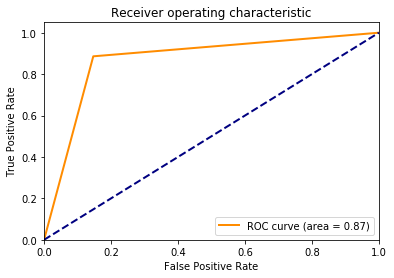

In [570]:
# Random under sampling for one class
rus = RandomUnderSampler(random_state=42)
ros = RandomOverSampler(random_state=42)
smote = SMOTE(random_state=42)
enn = EditedNearestNeighbours(random_state=42)
fit_evaluate(rus, X_train, y_train_1, X_test, y_test_1)

In [361]:
# SMOTE ENN sampling for class imbalance
fit_evaluate(smote_enn, X_train, y_train_1, X_test, y_test_1)

(103242, 93) (103242,)
Train score:  0.85015
Test score:  0.84712
Log loss train:  0.37417
Log loss test:  0.38388

Confusion Matrix: 
 [[5073  922]
 [  24  169]]

Classification Report: 
              precision    recall  f1-score   support

          0       1.00      0.85      0.91      5995
          1       0.15      0.88      0.26       193

avg / total       0.97      0.85      0.89      6188



In [506]:
RandomUnderSampler?

In [20]:
y_trains = [make_ovr_label(y_train, i) for i in np.arange(1,10)]
y_tests = [make_ovr_label(y_test, i) for i in np.arange(1,10)]

old y distribution:  Counter({2: 14510, 6: 12721, 8: 7618, 3: 7204, 9: 4459, 7: 2555, 5: 2465, 4: 2422, 1: 1736})
new y distribution:  Counter({0: 53954, 1: 1736})
old y distribution:  Counter({2: 14510, 6: 12721, 8: 7618, 3: 7204, 9: 4459, 7: 2555, 5: 2465, 4: 2422, 1: 1736})
new y distribution:  Counter({0: 41180, 1: 14510})
old y distribution:  Counter({2: 14510, 6: 12721, 8: 7618, 3: 7204, 9: 4459, 7: 2555, 5: 2465, 4: 2422, 1: 1736})
new y distribution:  Counter({0: 48486, 1: 7204})
old y distribution:  Counter({2: 14510, 6: 12721, 8: 7618, 3: 7204, 9: 4459, 7: 2555, 5: 2465, 4: 2422, 1: 1736})
new y distribution:  Counter({0: 53268, 1: 2422})
old y distribution:  Counter({2: 14510, 6: 12721, 8: 7618, 3: 7204, 9: 4459, 7: 2555, 5: 2465, 4: 2422, 1: 1736})
new y distribution:  Counter({0: 53225, 1: 2465})
old y distribution:  Counter({2: 14510, 6: 12721, 8: 7618, 3: 7204, 9: 4459, 7: 2555, 5: 2465, 4: 2422, 1: 1736})
new y distribution:  Counter({0: 42969, 1: 12721})
old y distribu

In [366]:
lrs = [LogisticRegression() for i in np.arange(1,10)] 

In [369]:
[lrs[i].fit(X_train,y_trains[i]) for i in np.arange(0,9)]

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state

In [408]:
predict_probs = [lrs[i].predict_proba(X_test.iloc[0:1,:]).flatten() for i in np.arange(0,9)]

In [409]:
predict_probs

[array([ 0.80384653,  0.19615347]),
 array([ 0.90601923,  0.09398077]),
 array([ 0.7894577,  0.2105423]),
 array([ 0.99716568,  0.00283432]),
 array([  9.99999986e-01,   1.43134517e-08]),
 array([ 0.83294029,  0.16705971]),
 array([ 0.90321867,  0.09678133]),
 array([ 0.78114804,  0.21885196]),
 array([ 0.65925352,  0.34074648])]

In [451]:
y_preds = []
y_pred_probs = []
for row in np.arange(0,X_test.shape[0]):
    predict_probs = [lrs[i].predict_proba(X_test.iloc[row:row+1,:]).flatten() for i in np.arange(0,9)]
    y_preds.append(np.argmax(np.transpose(predict_probs)[1])+1)
    y_pred_probs.append(np.transpose(predict_probs)[1])

In [457]:
y_pred_probs[0]

array([  1.96153474e-01,   9.39807717e-02,   2.10542301e-01,
         2.83432245e-03,   1.43134517e-08,   1.67059706e-01,
         9.67813285e-02,   2.18851960e-01,   3.40746481e-01])

In [442]:
y_test.shape

(6188,)

In [459]:
print("Log loss test: ",log_loss(y_test, y_pred_probs))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_preds))
print("\nClassification Report: \n", classification_report(y_test, y_preds))
    

Log loss test:  0.671511588758

Confusion Matrix: 
 [[  56   27    0    0    0   21    2   41   46]
 [   0 1438  138    5    8    6   10    5    2]
 [   0  565  217    3    0    1   10    3    1]
 [   0  168   29   45    4   19    4    0    0]
 [   0   15    2    0  257    0    0    0    0]
 [   3   34    1    3    0 1301   23   29   20]
 [   2   55   20    1    0   30  159   14    3]
 [  10   16    2    0    0   27   10  772    9]
 [   5   26    0    1    0   15    1   19  429]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.74      0.29      0.42       193
          2       0.61      0.89      0.73      1612
          3       0.53      0.27      0.36       800
          4       0.78      0.17      0.28       269
          5       0.96      0.94      0.95       274
          6       0.92      0.92      0.92      1414
          7       0.73      0.56      0.63       284
          8       0.87      0.91      0.89       846
          9

In [460]:
accuracy_score(y_test,y_preds)

0.7553329023917259

## One vs all with balanced classes

In [ ]:
# Balance the binary classes
rus = RandomUnderSampler(random_state=42)
X_oss = []
y_oss =[]
for i in np.arange(0,9):
    X_os, y_os = rus.fit_sample(X_train,y_trains[i])
    X_oss.append(X_os)
    y_oss.append(y_os)

In [22]:
lrs = [LogisticRegressionCV(cv=5) for i in np.arange(1,10)] 

In [23]:
[lrs[i].fit(X_oss[i],y_oss[i]) for i in np.arange(0,9)]

[LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
            refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
 LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
    

In [24]:
y_preds = []
y_pred_probs = []
for row in np.arange(0,X_test.shape[0]):
    predict_probs = [lrs[i].predict_proba(X_test.iloc[row:row+1,:]).flatten() for i in np.arange(0,9)]
    y_preds.append(np.argmax(np.transpose(predict_probs)[1])+1)
    y_pred_probs.append(np.transpose(predict_probs)[1])

In [25]:
print("Log loss test: ",log_loss(y_test, y_pred_probs))
print("\nConfusion Matrix: \n", confusion_matrix(y_test, y_preds))
print("\nClassification Report: \n", classification_report(y_test, y_preds))

Log loss test:  0.949572140707

Confusion Matrix: 
 [[ 105    4    0    0    1    5   10   27   41]
 [  16 1120  247  171   21    2   24    5    6]
 [   2  330  277  133    4    1   46    3    4]
 [   0   76   32  140    4   10    7    0    0]
 [   1    4    3    0  266    0    0    0    0]
 [  33   12    4   14    1 1259   34   29   28]
 [  21   14   10   14    2   11  201   10    1]
 [  38    4    4    1    0   14   15  753   17]
 [  41    6    0    2    0   12    4   14  417]]

Classification Report: 
              precision    recall  f1-score   support

          1       0.41      0.54      0.47       193
          2       0.71      0.69      0.70      1612
          3       0.48      0.35      0.40       800
          4       0.29      0.52      0.38       269
          5       0.89      0.97      0.93       274
          6       0.96      0.89      0.92      1414
          7       0.59      0.71      0.64       284
          8       0.90      0.89      0.89       846
          9